<div class="alert alert-block alert-info"> 
<h2>Problem Statement</h2> 

Some metastatic breast cancers are multi-drug resistant and result in increased lethality. Given two gene expression datasets – one with multi-drug resistant metastatic breast cancer, and one with unknown multi-drug resistant metastatic breast cancer – <br>
(a) **predict which patients in the unknown dataset are multidrug resistant.** And <br>
(b) **identify which biological mechanisms are governing this multidrug resistance.**
    
</div>

Jump to: <br>
**[Data pre-processing](#Data-Pre-processing)**<br>
**[Visualization](#Visualization)**<br>
**[Main analysis](#Main-analysis)**<br>
**[Predictions](#Predictions)**<br>
**[Identifying biological mechanisms](#Identify-biological-processes)**<br>


## Data Pre-processing



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

# Import data, indexed by genes
lethal = pd.read_csv('lethal.csv',index_col = 0).transform(lambda x: np.log10(x+1))
unknown = pd.read_csv('unknown.csv', index_col = 0).transform(lambda x: np.log10(x+1))

# Get common index
common_index = lethal.index.intersection(unknown.index)
tpm = pd.merge(lethal,unknown,left_index=True,right_index=True)

I use the `pyensembl` package to get the gene names from the gene IDs. I save these in a separate dataframe `genes` so I can grab gene names when I need to.

In [2]:
from pyensembl import EnsemblRelease

data = EnsemblRelease(77)
genes = pd.DataFrame({'gene_name':common_index}, index = common_index)
genes['gene_name'] = genes['gene_name'].apply(lambda x: data.gene_by_id(x).gene_name)
genes['biotype'] = genes.index.to_series().apply(lambda x: data.gene_by_id(x).biotype)

Next I try to parse the sample labels and identify unique labels for each set of data. **Assumptions about labels are added as comments.**

In [3]:
import re

Xlt = lethal.transpose().index.to_series()
Xlt = Xlt.apply(lambda x: re.sub("\AX\d{3}[_]\d{3}[_]","",x))
Xlt = Xlt.replace({"lungpleura" : "lung"})

print("lethal:")
print(np.sort(Xlt.unique()))

# This set of labels was more difficult to parse. 
Xut = unknown.transpose().index.to_series().apply(lambda x: x.lower())
pattern = r'(^a\d+[.])|(\W)|(rna$)|(\d)|(met\d*\b)|(ffpe)'
Xut = Xut.apply(lambda x: re.sub(pattern,"",x))
Xut = Xut.apply(lambda x: re.sub(r'liv\w*',"liver",x))
Xut = Xut.apply(lambda x: re.sub(r'skin\w*',"skin",x))
Xut = Xut.apply(lambda x: re.sub(r'brain\w*',"brain",x))
Xut = Xut.apply(lambda x: re.sub(r'lung\w*',"lung",x))

# Assuming all labels containing string 'adre' mean adrenal, choosing to group these with lymph nodes
Xut = Xut.apply(lambda x: re.sub(r'adre\w*',"LN",x)) 

# Assuming LN is lymph node
Xut = Xut.apply(lambda x: re.sub(r'\w*ln\w*',"LN",x)) 

# Assuming all labels containing string 'prim' refer to primary tumor, in this case breast
Xut = Xut.apply(lambda x: re.sub(r'prim\w*',"breast",x)) 

# Assuming PT also refers to primary tumor
Xut = Xut.apply(lambda x: re.sub(r'pt\w*',"breast",x)) 

# Assuming pleura refers to lung pleura, "ova" is ovary, etc.
d = {"pleura" : "lung", "ovarna" : "ovary", "duramater" : "meninges", "kidny" : "kidney"}

# Assuming 'lll' and 'rll' and 'lul' refer to lung regions "left lower lobe" etc.
d.update(dict.fromkeys(['lll', 'rll', 'lul'], "lung"))

# Assuming "skull", "spin" (spine), "rib", and "bspi" can be grouped together as "bone"
d.update(dict.fromkeys(['skull', 'spin', 'rib', 'bspi'], "bone")) 

# Assuming "mediastn" and "chestwall" can be grouped with "chest"
d.update(dict.fromkeys(['mediastn', 'chestwall'], "chest")) 


Xut = Xut.replace(d)
print("unknown:")
print(np.sort(Xut.unique()))

Xs = pd.concat([Xlt,Xut]).reset_index()

lethal:
['LN' 'bone' 'brain' 'breast' 'liver' 'lung' 'meninges' 'ovary'
 'pericardium' 'stomach']
unknown:
['LN' 'bone' 'brain' 'breast' 'celeb' 'chest' 'kidney' 'liver' 'lung'
 'meninges' 'ovary' 'pancreas' 'skin' 'softtissue']


There are 16 unique labels. I could try to group these into fewer categories, but I'm not sure yet that it is necessary. For now I will create the dataframe `X` to be used for the PCA analysis. 

In [4]:
X1 = lethal.transpose()
X1['group'], X1['label'] = 0, Xlt
X2 = unknown.transpose()
X2['group'], X2['label'] = 1, Xut
X = pd.concat([X1,X2]).reset_index(drop = True)
y = X.filter(['group','label'], axis = 1)
X.drop(columns = ['group','label'], inplace = True)

## Visualization

### PCA

In [5]:
from sklearn.decomposition import PCA

pca = PCA() # All components
PCdata = pca.fit_transform(X)
df = pd.concat([pd.DataFrame(data = PCdata), y], axis = 1)
PCAstats = pd.DataFrame({'standard deviation':np.sqrt(pca.explained_variance_),
                        'explained variance ratio':pca.explained_variance_ratio_,
                        'cumulative variance ratio':np.cumsum(pca.explained_variance_ratio_)})

pd.set_option('display.max_rows', None)
print(PCAstats)

     standard deviation  explained variance ratio  cumulative variance ratio
0          6.086143e+00              4.023376e-01                   0.402338
1          2.672387e+00              7.757201e-02                   0.479910
2          2.387696e+00              6.192479e-02                   0.541834
3          1.922821e+00              4.015913e-02                   0.581994
4          1.860859e+00              3.761259e-02                   0.619606
5          1.678054e+00              3.058568e-02                   0.650192
6          1.531485e+00              2.547604e-02                   0.675668
7          1.359982e+00              2.008967e-02                   0.695758
8          1.258043e+00              1.719086e-02                   0.712948
9          1.203584e+00              1.573472e-02                   0.728683
10         1.172451e+00              1.493123e-02                   0.743614
11         1.087329e+00              1.284187e-02                   0.756456

<IPython.core.display.Javascript object>


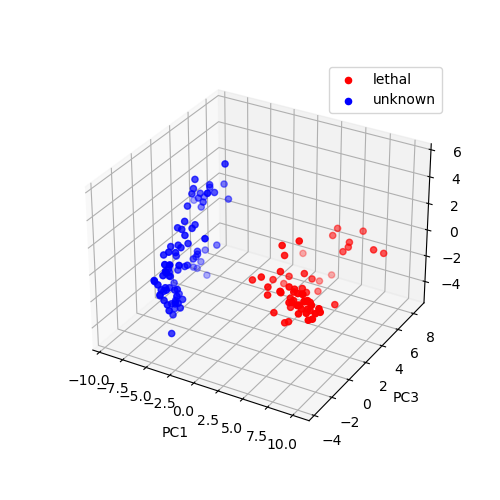

In [6]:
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_ylabel('PC3')
targets, groups, colors = ['lethal', 'unknown'], [0, 1], ['r', 'b']
for target, color in zip(groups,colors):
    indicesToKeep = df['group'] == target
    ax.scatter(df.loc[indicesToKeep, 0],
               df.loc[indicesToKeep, 1],
               df.loc[indicesToKeep, 3],
               c = color,
               s = 20)
ax.legend(targets)
ax.grid()

Identify the genes involved in the largest variability.

In [7]:
pcomps = pd.DataFrame(data = np.transpose(abs(pca.components_)), index = common_index)
top_genes = pd.Series(dtype = object)

for i in range(5): top_genes = pd.concat([top_genes, pcomps.iloc[:,i].nlargest(50).index.to_series()], join = "inner")
top_genes.drop_duplicates(inplace = True)

# Add in all the other info from the `genes` dataframe
top_genes.name = "top genes"
top_genes = pd.merge(top_genes, genes, how = "left", left_index = True, right_index = True)
top_genes.drop(columns = ['top genes'], inplace = True)

Preparing reduced data set. 

In [8]:
X1 = lethal.filter(top_genes.index,axis=0).transpose()
X1['group'], X1['label'] = 0, Xlt
X2 = unknown.filter(top_genes.index,axis=0).transpose()
X2['group'], X2['label'] = 1, Xut
X = pd.concat([X1,X2]).reset_index(drop = True)
tpm_top = X.copy()
y = X.filter(['group','label'], axis = 1)
X.drop(columns = ['group','label'], inplace = True)

### UMAP projection

<IPython.core.display.Javascript object>


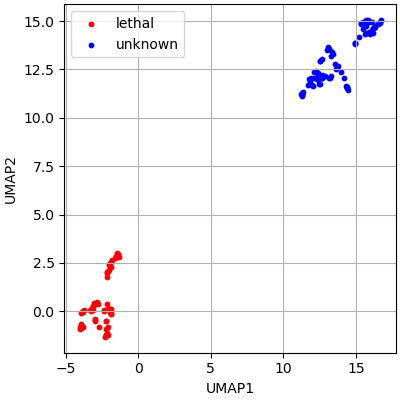

In [9]:
from umap import UMAP

umap1 = UMAP(random_state = 1234, min_dist = 0) # All components
UMAPdata = umap1.fit_transform(X)
df = pd.concat([pd.DataFrame(data = UMAPdata), y], axis = 1)

fig = plt.figure(figsize = (4,4),constrained_layout=True)
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
targets, groups, colors = ['lethal', 'unknown'], [0, 1], ['r', 'b']
for target, color in zip(groups,colors):
    indicesToKeep = df['group'] == target
    ax.scatter(df.loc[indicesToKeep, 0],
               df.loc[indicesToKeep, 1],
               c = color,
               s = 10)
ax.legend(targets)
ax.grid()

### Clustering with DBSCAN

<IPython.core.display.Javascript object>


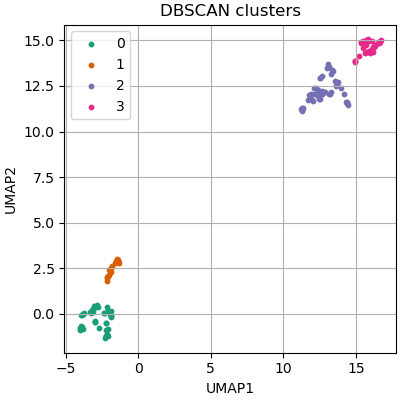

In [10]:
from sklearn.cluster import DBSCAN
from matplotlib.cm import get_cmap

dbscan = DBSCAN(eps = 0.65, min_samples = 5).fit(UMAPdata)
df = pd.concat([pd.DataFrame(data = UMAPdata),  y], axis = 1)
df["cluster"] = dbscan.labels_

fig = plt.figure(figsize = (4,4),constrained_layout=True)
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('DBSCAN clusters')
num = df["cluster"].nunique()
cmap = get_cmap('Dark2')
groups, colors = range(num), cmap(range(num))
for target, color in zip(groups,colors):
    indicesToKeep = df['cluster'] == target
    ax.scatter(df.loc[indicesToKeep, 0],
               df.loc[indicesToKeep, 1],
               color = color,
               s = 10)
ax.legend(range(num))
ax.grid()

I played around with the UMAP seed and DBSCAN parameters, but only consistently was able to get 4 clusters. I could get more but they were not stable across different runs of UMAP with different random states. 

## Main analysis

Looking at what the top labels are generally.

In [11]:
tpm_top["cluster"] = df["cluster"].copy()
tpm_top["label"].value_counts()

liver          30
lung           26
LN             19
brain          19
breast         17
bone           11
meninges        9
pericardium     3
chest           3
ovary           2
pancreas        2
skin            2
stomach         1
celeb           1
softtissue      1
kidney          1
Name: label, dtype: int64

The top labels are `liver`, `lung`, `LN`, `brain`, and `breast`. Seeing what the counts are for each label in each cluster. 

In [12]:
tpm_top.groupby("cluster")["label"].value_counts()

cluster  label      
0        liver          13
         lung            8
         LN              7
         meninges        6
         bone            5
         pericardium     3
         breast          2
         ovary           1
         stomach         1
1        brain          10
         liver           3
         LN              2
         meninges        2
         lung            1
2        breast         13
         brain           9
         liver           9
         lung            7
         LN              5
         bone            3
         chest           3
         skin            2
         celeb           1
         kidney          1
3        lung           10
         LN              5
         liver           5
         bone            3
         breast          2
         pancreas        2
         meninges        1
         ovary           1
         softtissue      1
Name: label, dtype: int64

Clusters `0` and `1` contain only the `lethal` dataset and clusters `2` and `3` the `unknown` data set. Immediately I see that Clusters `1` and `2` have subclusters of `brain` labels, and no `brain` labels in the other clusters. I will focus on this first. 

Plotting and color-coding by the top five labels to see if anything else stands out:

<IPython.core.display.Javascript object>


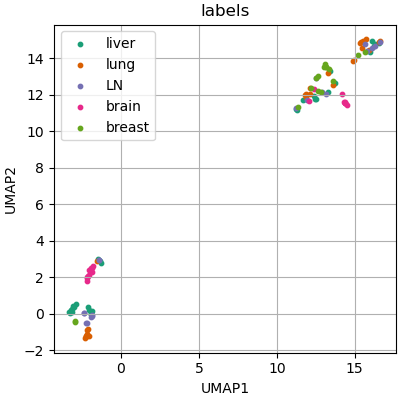

In [13]:
fig = plt.figure(figsize = (4,4),constrained_layout=True)
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('labels')
num = 5
cmap = get_cmap('Dark2')
groups, colors = ['liver', 'lung', 'LN', 'brain', 'breast'], cmap(range(num))
for target, color in zip(groups,colors):
    indicesToKeep = df['label'] == target
    ax.scatter(df.loc[indicesToKeep, 0],
               df.loc[indicesToKeep, 1],
               color = color,
               s = 10)
ax.legend(groups)
ax.grid()

- Clusters `0`, `2`, and `3` have `lung` subclusters
- `liver` is in all clusters but slightly more samples in clusters `0` and `2`

### Approach

The approach that I'm going to take is to make educated guesses about interesting subsets of the `top_genes` to look at through the same type of cluster analysis as above. I'm going to use statistical tests to reduce the top genes into subsets to look into. First defining some functions I'll be using multiple times.

In [14]:
# Further reduce a set of genes through PCA
def get_gene_subset(X,y,index,name):
    pca = PCA() # All components
    PCdata = pca.fit_transform(X)
    df = pd.concat([pd.DataFrame(data = PCdata), y], axis = 1)
    pcomps = pd.DataFrame(data = np.transpose(abs(pca.components_)), index = index)
    top_genes = pd.Series(dtype = object)

    # Top 10 genes that contribute to each of the first five PCs
    for i in range(5): top_genes = pd.concat([top_genes, pcomps.iloc[:,i].nlargest(10).index.to_series()], join = "inner")
    top_genes.drop_duplicates(inplace = True)

    # Add in all the other info from the `genes` dataframe
    top_genes.name = "top genes " + name
    top_genes = pd.merge(top_genes, genes, how = "left", left_index = True, right_index = True)
    top_genes.drop(columns = [("top genes " + name)], inplace = True)
    print("number of genes in subset:")
    print(len(top_genes))
    return top_genes

# Filter by index only
def get_Xy_reduced(df,index): 
    y = df.filter(["group", "label", "cluster"])
    df_top = df.filter(index.values,axis=1)
    df_top = pd.concat([df_top,  y], axis = 1)
    y = df_top.filter(["group", "label", "cluster"])
    X = df_top.drop(["group", "label", "cluster"], axis = 1)
    return X, y

# Filter by index and label
def get_Xy_red_label(df,index,label): 
    y = df.filter(["group", "label", "cluster"])
    df_top = df.filter(index.values,axis=1)
    df_top = pd.concat([df_top,  y], axis = 1)
    df_top = df_top.where(y.label == label).dropna()
    y = df_top.filter(["group", "label", "cluster"]).reset_index()
    X = df_top.drop(["group", "label", "cluster"], axis = 1).reset_index(drop=True)
    return X, y

# Do UMAP projection and DBSCAN clustering and plot
def plot_clusters(X,y,eps,min_samples,random_state):
    umap2 = UMAP(random_state = random_state, min_dist = 0) # All components
    UMAPdata = umap2.fit_transform(X)
    df = pd.concat([pd.DataFrame(data = UMAPdata), y], axis = 1)

    fig = plt.figure(figsize = (9,3),constrained_layout=True)
    ax = fig.add_subplot(1,3,1) 
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    targets, groups, colors = ['lethal', 'unknown'], [0, 1], ['r', 'b']
    for target, color in zip(groups,colors):
        indicesToKeep = df['group'] == target
        ax.scatter(df.loc[indicesToKeep, 0],
                   df.loc[indicesToKeep, 1],
                   c = color,
                   s = 10)
    ax.legend(targets)
    ax.grid()

    dbscan = DBSCAN(eps = eps, min_samples = min_samples).fit(UMAPdata)
    df = pd.concat([pd.DataFrame(data = UMAPdata),  y], axis = 1)
    df["cluster"] = dbscan.labels_

    ax = fig.add_subplot(1,3,2) 
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_title('DBSCAN clusters')
    num = df["cluster"].nunique()
    cmap = get_cmap('Dark2')
    groups, colors = range(num), cmap(range(num))
    for target, color in zip(groups,colors):
        indicesToKeep = df['cluster'] == target
        ax.scatter(df.loc[indicesToKeep, 0],
                   df.loc[indicesToKeep, 1],
                   color = color,
                   s = 10)
    ax.legend(range(num))
    ax.grid()
   
    ax = fig.add_subplot(1,3,3) 
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_title('labels')
    num = 5
    cmap = get_cmap('Dark2')
    groups, colors = ['liver', 'lung', 'LN', 'brain', 'breast'], cmap(range(num))
    for target, color in zip(groups,colors):
        indicesToKeep = df['label'] == target
        ax.scatter(df.loc[indicesToKeep, 0],
                   df.loc[indicesToKeep, 1],
                   color = color,
                   s = 10)
    ax.legend(groups)
    ax.grid()
    return df

# t-tests of the lethal and unknown datasets filtered by some given label (liver, lung, etc.)
def group_t_test_by_label(X,y,label):
    t_test_results = {}
    for column in X.columns:
        cluster1 = X.where((y.group == 0) & (y.label == label)).dropna()[column]
        cluster2 = X.where((y.group == 1) & (y.label == label)).dropna()[column]
        t_test_results[column] = ttest_ind(cluster1,cluster2)
    results = pd.DataFrame.from_dict(t_test_results,orient='Index')
    results.columns = ['statistic','pvalue']
    results = results[results['pvalue']<0.05]
    return results.sort_values('pvalue')

# t-test of cluster vs rest of the clusters
def cluster_t_test(X,y,cluster):
    t_test_results = {}
    for column in X.columns:
        cluster1 = X.where(y.cluster == cluster).dropna()[column]
        cluster2 = X.where(y.cluster != cluster).dropna()[column]
        t_test_results[column] = ttest_ind(cluster1,cluster2)
    results = pd.DataFrame.from_dict(t_test_results,orient='Index')
    results.columns = ['statistic','pvalue']
    results = results[results['pvalue']<0.05]
    return results.sort_values('pvalue')

# returns the unknown samples from a cluster
def get_samples(df,Xs,cluster):
    output = df[df.cluster == cluster].drop(df.columns[0:2], axis = 1)
    output = pd.merge(output,Xs,left_index = True, right_index = True).set_index("index").filter(["group"], axis = 1)
    output = output[output["group"]==1].filter(["label"],axis =1)
    return output

I begin by performing a t-test for the two groups and keeping only the genes that are significantly different. This reduces the number of genes from 236 down to 151.

In [15]:
from scipy.stats import ttest_ind, f_oneway

y = tpm_top.filter(["group", "label", "cluster"])
X = tpm_top.drop(["group", "label", "cluster"], axis = 1)
t_test_results = {}
for column in X.columns:
    group1 = X.where(y.group == 0).dropna()[column]
    group2 = X.where(y.group == 1).dropna()[column]
    t_test_results[column] = ttest_ind(group1,group2)
results_df1 = pd.DataFrame.from_dict(t_test_results,orient='Index')
results_df1.columns = ['statistic-g','pvalue-g']
results_df1 = results_df1[results_df1['pvalue-g']<0.05]
print(results_df1.shape)

(151, 2)


Next is to look at variability between clusters.

In [16]:
f_test_results = {}
for column in X.columns:
    cluster1 = X.where(y.cluster == 0).dropna()[column]
    cluster2 = X.where(y.cluster == 1).dropna()[column]
    cluster3 = X.where(y.cluster == 2).dropna()[column]
    cluster4 = X.where(y.cluster == 3).dropna()[column]
    f_test_results[column] = f_oneway(cluster1,cluster2,cluster3,cluster4)
results_df2 = pd.DataFrame.from_dict(f_test_results,orient='Index')
results_df2.columns = ['statistic-c','pvalue-c']
results_df2 = results_df2[results_df2['pvalue-c']<0.05]
print(results_df2.shape)

(226, 2)


Intersection of above sets of genes gets us down to 149.

In [17]:
results_df = pd.merge(results_df1, results_df2, left_index=True, right_index=True)
print(results_df.shape)

(149, 4)


Then doing the UMAP/DBSCAN clustering for this subset of genes

<IPython.core.display.Javascript object>


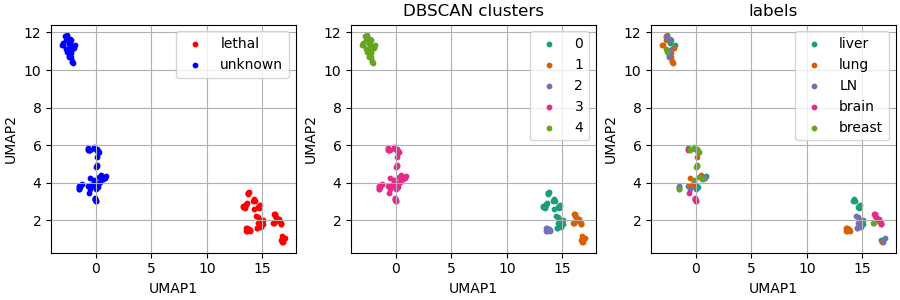

In [18]:
X, y = get_Xy_reduced(tpm_top, results_df.index)
df = plot_clusters(X,y,0.7,3,1234)

I notice the UMAP projection is a little different than before. There are still two main groups of `unknown` labels and now one larger one containing all the `lethal` samples. The DSBSCAN clustering separates the `lethal` group into three clusters and I see these overlap with labels (cluster 2 is all lung, for example). This is a good starting point. I am going to redefine the top genes as this set.

In [19]:
tpm_top = tpm_top.filter(results_df.index, axis = 1)
tpm_top = pd.concat([tpm_top,y],axis = 1)
top_genes = top_genes.filter(results_df.index, axis = 0)

### Brain

Now I'm going to focus on the `brain` data first because it originally stood out to me. Performing a t-test for the two datasets, filtered to just the samples labelled `brain`. This is to see what's different between the two brain groups. I'm looking out for dense clustering of `unknown` and `lethal` samples.

In [20]:
results_brain = group_t_test_by_label(X,y,"brain")
results_brain = pd.merge(results_df, results_brain, left_index=True, right_index=True)
print(results_brain.shape)

(99, 6)


I now have a subset of 99 genes. The `brain` sample set has only 19 samples, so I am going to reduce this number of genes again through PCA. Then I'm going to look at the full set of samples but just this brain-subset of genes.

number of genes in subset:
38


<IPython.core.display.Javascript object>


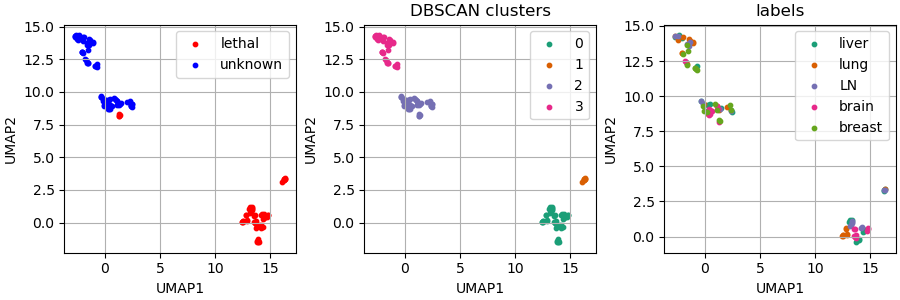

In [21]:
X, y = get_Xy_red_label(tpm_top,results_brain.index,"brain")
top_genes_brain = get_gene_subset(X,y,results_brain.index,"brain")
X, y = get_Xy_reduced(tpm_top, top_genes_brain.index)
df_brain = plot_clusters(X,y,0.9,3,1234)

I notice that there are `lethal` and `unknown` samples within a single cluster (cluster 3). Now to get what those samples are and save them as a possibly lethal group. I also want to know what genes are responsible for the differentiation between cluster 2 and the rest of the clusters

In [22]:
y["cluster"] = df_brain["cluster"]
# goi -> genes of interest
goi_brain = cluster_t_test(X,y,3)
maybe_brain = get_samples(df_brain,Xs,3)

Another interesting subset to look at are just the genes that were *excluded* by the t-test, because they are still genes that contribute to variability in the broader dataset. So the "excluded" genes are just the top genes that are *not* significantly different between `lethal` and `unknown` brain samples.

number of genes in subset:
30


<IPython.core.display.Javascript object>


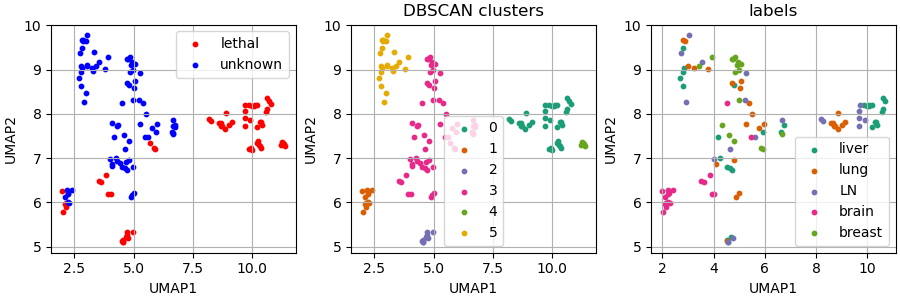

In [23]:
excluded = tpm_top.drop(["group", "label", "cluster"], axis = 1)
excluded = excluded.drop(results_brain.index, axis = 1).T
X, y = get_Xy_red_label(tpm_top,excluded.index,"brain")
ex_genes_brain = get_gene_subset(X,y,excluded.index,"brain")
X, y = get_Xy_reduced(tpm_top, ex_genes_brain.index)
df_brain_ex = plot_clusters(X,y,0.7,3,1234)

I notice some dense clustering of brain labels in cluster 1, so I am including them as samples of interest.

In [24]:
maybe_brain_ex = get_samples(df_brain_ex,Xs,1)
maybe_brain = pd.merge(maybe_brain,maybe_brain_ex,how = "outer", left_index = True, right_index = True)
# goi -> genes of interest
goi_brain = pd.merge(goi_brain,cluster_t_test(X,y,1),how = "outer", left_index = True, right_index = True)

### Lung

Same analysis for the other top labels

number of genes in subset:
42


<IPython.core.display.Javascript object>


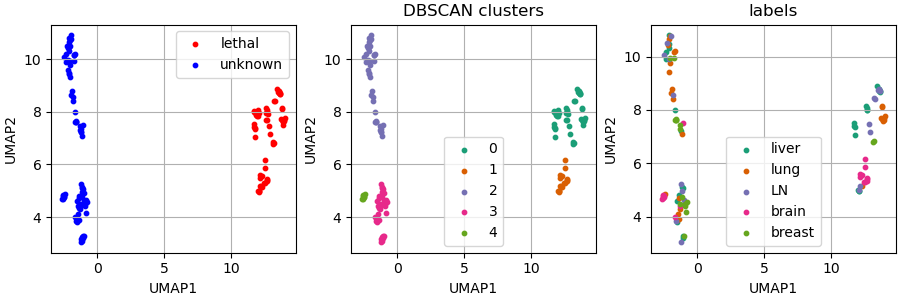

In [25]:
y = tpm_top.filter(["group", "label", "cluster"])
X = tpm_top.drop(["group", "label", "cluster"], axis = 1)
results_lung = group_t_test_by_label(X,y,"lung")
results_lung = pd.merge(results_df, results_lung, left_index=True, right_index=True)
X, y = get_Xy_red_label(tpm_top, results_lung.index, "lung")
top_genes_lung = get_gene_subset(X,y,results_lung.index,"lung")
X, y = get_Xy_reduced(tpm_top, top_genes_lung.index)
df_lung = plot_clusters(X,y,0.8,3,1234)

number of genes in subset:
37


<IPython.core.display.Javascript object>


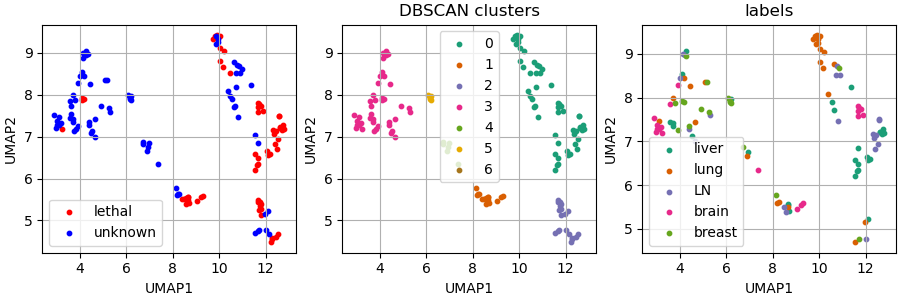

In [26]:
label = "lung"
excluded = tpm_top.drop(["group", "label", "cluster"], axis = 1)
excluded = excluded.drop(results_lung.index, axis = 1).T
X, y = get_Xy_red_label(tpm_top,excluded.index,label)
ex_genes_lung = get_gene_subset(X,y,excluded.index,label)
X, y = get_Xy_reduced(tpm_top, ex_genes_lung.index)
df_lung_ex = plot_clusters(X,y,0.6,3,1234)

Clusters 0, 1, and 2 are all interesting, they have similar counts of `unknown` and `lethal` samples.

In [27]:
maybe_lung0 = get_samples(df_lung_ex,Xs,0)
maybe_lung1 = get_samples(df_lung_ex,Xs,1)
maybe_lung2 = get_samples(df_lung_ex,Xs,2)

goi_lung0 = cluster_t_test(X,y,0)
goi_lung1 = cluster_t_test(X,y,1)
goi_lung2 = cluster_t_test(X,y,2)

# Intersection of genes
goi_lung = pd.merge(goi_lung0,goi_lung1,right_index = True, left_index = True)
goi_lung =  pd.merge(goi_lung,goi_lung2,right_index = True, left_index = True).drop(goi_lung.columns, axis = 1)

# Union of samples
maybe_lung = pd.merge(maybe_lung0,maybe_lung1,how = "outer",right_index = True, left_index = True)
maybe_lung =  pd.merge(maybe_lung,maybe_lung2,how = "outer",right_index = True, left_index = True).drop(maybe_lung.columns, axis = 1)

### Liver

number of genes in subset:
45


<IPython.core.display.Javascript object>


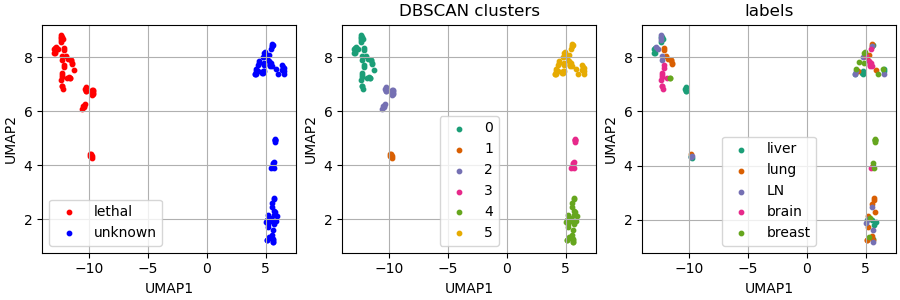

In [28]:
label = "liver"
y = tpm_top.filter(["group", "label", "cluster"])
X = tpm_top.drop(["group", "label", "cluster"], axis = 1)
results_liver = group_t_test_by_label(X,y,label)
results_liver = pd.merge(results_df, results_liver, left_index=True, right_index=True)
X, y = get_Xy_red_label(tpm_top, results_liver.index, label)
top_genes_liver = get_gene_subset(X,y,results_liver.index,label)
X, y = get_Xy_reduced(tpm_top, top_genes_liver.index)
df_liver = plot_clusters(X,y,0.8,3,1234)

number of genes in subset:
29


<IPython.core.display.Javascript object>


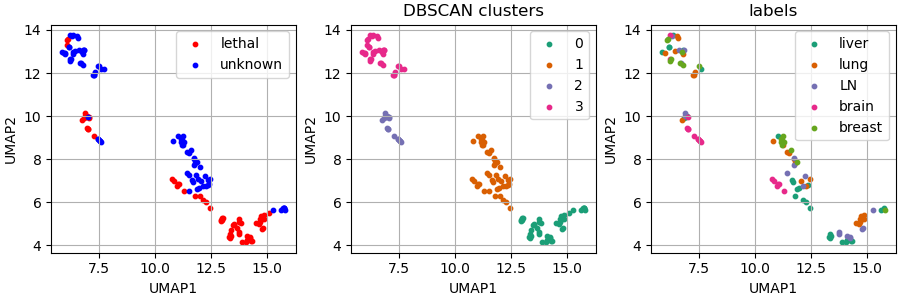

In [29]:
label = "liver"
excluded = tpm_top.drop(["group", "label", "cluster"], axis = 1)
excluded = excluded.drop(results_liver.index, axis = 1).T
X, y = get_Xy_red_label(tpm_top,excluded.index,label)
ex_genes_liver = get_gene_subset(X,y,excluded.index,label)
X, y = get_Xy_reduced(tpm_top, ex_genes_liver.index)
df_liver_ex = plot_clusters(X,y,0.65,3,1234)

Cluster 2 has subclustering of brain labels. Also including clusters 0 and 1.

In [30]:
maybe_liver0 = get_samples(df_liver_ex,Xs,0)
maybe_liver1 = get_samples(df_liver_ex,Xs,1)
maybe_liver2 = get_samples(df_liver_ex,Xs,2)

goi_liver0 = cluster_t_test(X,y,0)
goi_liver1 = cluster_t_test(X,y,1)
goi_liver2 = cluster_t_test(X,y,2)

# Intersection of genes
goi_liver = pd.merge(goi_liver0,goi_liver1,right_index = True, left_index = True)
goi_liver =  pd.merge(goi_liver,goi_liver2,right_index = True, left_index = True).drop(goi_liver.columns, axis = 1)

# Union of samples
maybe_liver = pd.merge(maybe_liver0,maybe_liver1,how = "outer",right_index = True, left_index = True)
maybe_liver =  pd.merge(maybe_liver,maybe_liver2,how = "outer",right_index = True, left_index = True).drop(maybe_liver.columns, axis = 1)

### Lymph nodes

number of genes in subset:
39


<IPython.core.display.Javascript object>


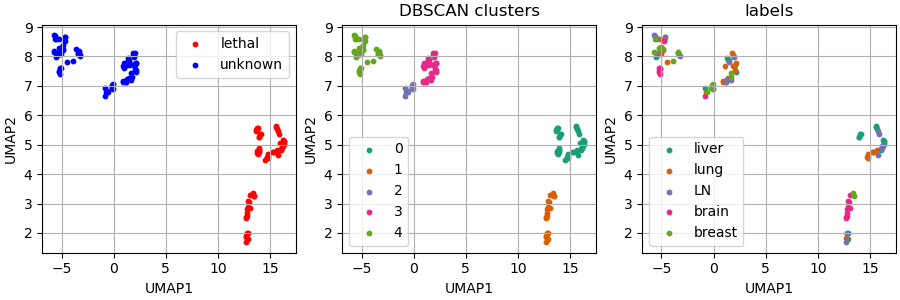

In [31]:
label = "LN"
y = tpm_top.filter(["group", "label", "cluster"])
X = tpm_top.drop(["group", "label", "cluster"], axis = 1)
results_LN = group_t_test_by_label(X,y,label)
results_LN = pd.merge(results_df, results_LN, left_index=True, right_index=True)
X, y = get_Xy_red_label(tpm_top, results_LN.index, label)
top_genes_LN = get_gene_subset(X,y,results_LN.index,label)
X, y = get_Xy_reduced(tpm_top, top_genes_LN.index)
df_LN = plot_clusters(X,y,0.8,3,1234)

number of genes in subset:
35


<IPython.core.display.Javascript object>


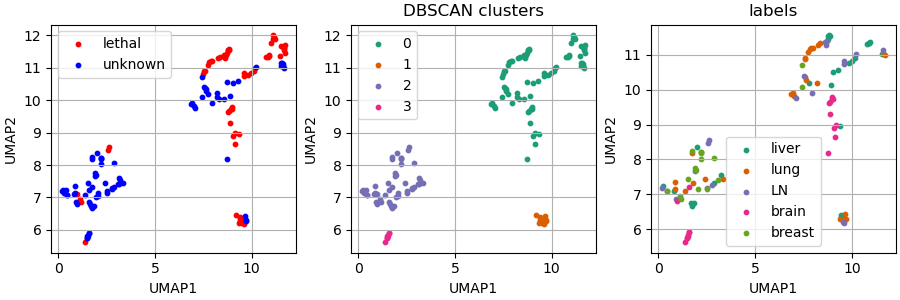

In [32]:
label = "LN"
excluded = tpm_top.drop(["group", "label", "cluster"], axis = 1)
excluded = excluded.drop(results_LN.index, axis = 1).T
X, y = get_Xy_red_label(tpm_top,excluded.index,label)
ex_genes_LN = get_gene_subset(X,y,excluded.index,label)
X, y = get_Xy_reduced(tpm_top, ex_genes_LN.index)
df_LN_ex = plot_clusters(X,y,0.70,3,1234)

Subclusters of lung and brain in cluster 0. Cluster 1 is also a very dense cluster, which is interesting.

In [33]:
maybe_LN0 = get_samples(df_LN_ex,Xs,0)
maybe_LN1 = get_samples(df_LN_ex,Xs,1)

goi_LN0 = cluster_t_test(X,y,0)
goi_LN1 = cluster_t_test(X,y,1)

goi_LN = pd.merge(goi_LN0,goi_LN1,right_index = True, left_index = True)
maybe_LN = pd.merge(maybe_LN0,maybe_LN1,how = "outer",right_index = True, left_index = True)

### Breast

number of genes in subset:
37


<IPython.core.display.Javascript object>


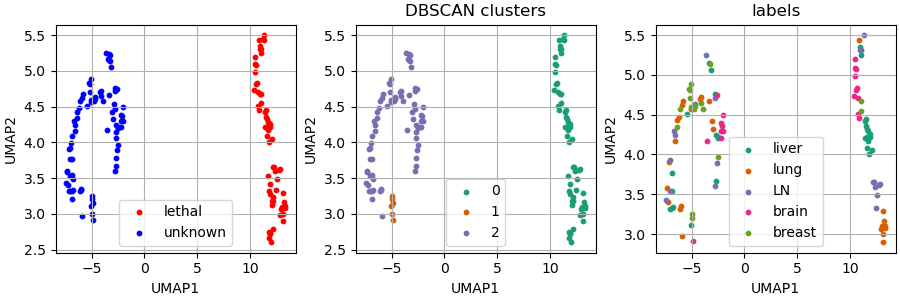

In [34]:
label = "breast"
y = tpm_top.filter(["group", "label", "cluster"])
X = tpm_top.drop(["group", "label", "cluster"], axis = 1)
results_breast = group_t_test_by_label(X,y,label)
results_breast = pd.merge(results_df, results_breast, left_index=True, right_index=True)
X, y = get_Xy_red_label(tpm_top, results_breast.index, label)
top_genes_breast = get_gene_subset(X,y,results_breast.index,label)
X, y = get_Xy_reduced(tpm_top, top_genes_breast.index)
df_breast = plot_clusters(X,y,0.8,3,1234)

number of genes in subset:
38


<IPython.core.display.Javascript object>


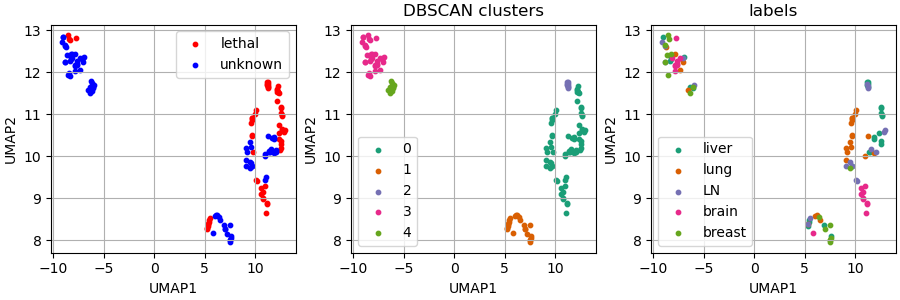

In [35]:
label = "breast"
excluded = tpm_top.drop(["group", "label", "cluster"], axis = 1)
excluded = excluded.drop(results_breast.index, axis = 1).T
X, y = get_Xy_red_label(tpm_top,excluded.index,label)
ex_genes_breast = get_gene_subset(X,y,excluded.index,label)
X, y = get_Xy_reduced(tpm_top, ex_genes_breast.index)
df_breast_ex = plot_clusters(X,y,0.65,3,1234)

I am choosing clusters 0 and 1 because I see clustering of `unknown` lung and breast in each and they have similar numbers of `unknown` and `lethal` samples within each.

In [36]:
maybe_breast0 = get_samples(df_breast_ex,Xs,0)
maybe_breast1 = get_samples(df_breast_ex,Xs,1)

goi_breast0 = cluster_t_test(X,y,0)
goi_breast1 = cluster_t_test(X,y,1)

goi_breast = pd.merge(goi_breast0,goi_breast1,right_index = True, left_index = True)
maybe_breast = pd.merge(maybe_breast0,maybe_breast1,how = "outer",right_index = True, left_index = True)

### Bone

number of genes in subset:
41


<IPython.core.display.Javascript object>


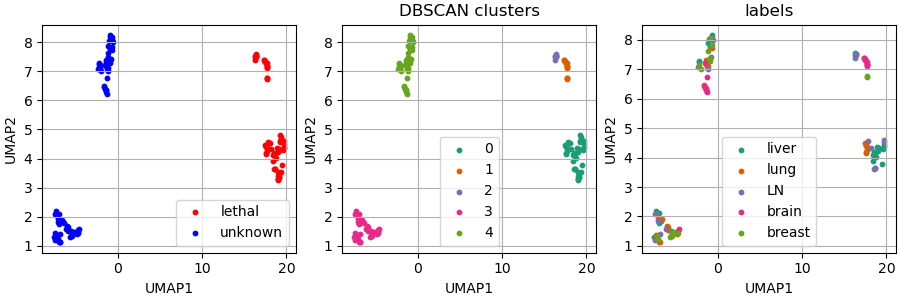

In [37]:
label = "bone"
y = tpm_top.filter(["group", "label", "cluster"])
X = tpm_top.drop(["group", "label", "cluster"], axis = 1)
results_bone = group_t_test_by_label(X,y,label)
results_bone = pd.merge(results_df, results_bone, left_index=True, right_index=True)
X, y = get_Xy_red_label(tpm_top, results_bone.index, label)
top_genes_bone = get_gene_subset(X,y,results_bone.index,label)
X, y = get_Xy_reduced(tpm_top, top_genes_bone.index)
df_bone = plot_clusters(X,y,0.8,3,1234)

number of genes in subset:
37


<IPython.core.display.Javascript object>


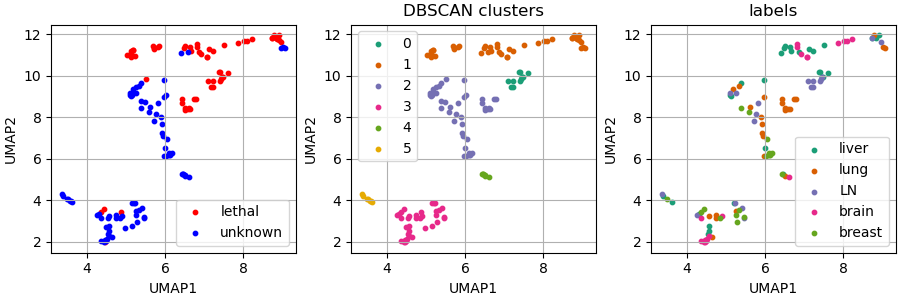

In [38]:
label = "bone"
excluded = tpm_top.drop(["group", "label", "cluster"], axis = 1)
excluded = excluded.drop(results_bone.index, axis = 1).T
X, y = get_Xy_red_label(tpm_top,excluded.index,label)
ex_genes_bone = get_gene_subset(X,y,excluded.index,label)
X, y = get_Xy_reduced(tpm_top, ex_genes_bone.index)
df_bone_ex = plot_clusters(X,y,0.70,3,1234)

Not so sure about these clusters. Not including them.

## Predictions

My predictions will be any samples that are common to all the `maybe` lists, which means they were repeatedly clustered with either large numbers of `lethal` samples or in a very dense cluster of `lethal` samples.

In [45]:
predictions = maybe_lung.copy()
maybes = [maybe_liver, maybe_LN, maybe_breast]

for dfs in maybes:
    predictions = pd.merge(predictions,dfs,how = 'inner',left_index = True, right_index = True)
    predictions.drop(predictions.columns, inplace = True,axis = 1)

predictions

""
index
A12.AdrenalG.Met.RNA
A12.LIV.MET.RNA
A12.LN.Met.subcarinal.RNA
A12.PRIMT020076B.RNA
A12.PleuraMet.RNA
A12.RLL.MET.RNA
A12.SkullMet.RNA
A2.LN.Met.Subcarinal.RNA
A2.LungMet.RNA


If I interpret each A# as a patient, there are 16 patients in the `unknown` dataset. 6 of them show up in the predictions. 

Number of samples in predictions/total samples for each patient
- *A12* 7/7 
- *A2* 2/4 
- *A28* 6/7 
- *A34* 4/5 
- *A4* 3/3
- *A8* 5/5

I am going to exclude A2 because only 2 out of the 4 samples were present in all the clusters of interest. For the other 5, the majority (or all) of the samples were in the clusters of interest. **My final predictions for the patients that are multidrug resistant are A12, A28, A34, A4, and A8.**

## Identify biological processes

Compiling the set of all genes that contributed to the clusters used for the predictions. 

In [40]:
genes_of_interest = goi_brain.copy()
goi = [goi_lung, goi_liver, goi_LN, goi_breast]

for dfs in goi:
    genes_of_interest = pd.merge(genes_of_interest,dfs,how = 'outer',left_index = True, right_index = True)
    genes_of_interest.drop(genes_of_interest.columns, inplace = True,axis = 1)
    
genes_of_interest = genes.filter(genes_of_interest.index.values, axis = 0)

Saving the gene_IDs in a csv to run through PANTHER

In [41]:
#pd.DataFrame(index = genes_of_interest.index.values).to_csv("genes_of_interest.csv")

I ran the list through the PANTHER overrepresentation test and looked at the resulting biological processes with smallest p-values which were **cell differentiation** and **cellular development process**. I cross-checked many of the genes on proteinatlas.org and some of the relevant biological processes that were also showing up on PANTHER were *cell adhesion, apoptosis, neurogenesis,* and *ion transport.*

In [42]:
genes_of_interest.sort_values('gene_name')

,gene_name,biotype
ENSG00000179869,ABCA13,protein_coding
ENSG00000154262,ABCA6,protein_coding
ENSG00000106541,AGR2,protein_coding
ENSG00000116194,ANGPTL1,protein_coding
ENSG00000115266,APC2,protein_coding
ENSG00000156219,ART3,protein_coding
ENSG00000018625,ATP1A2,protein_coding
ENSG00000185883,ATP6V0C,protein_coding
ENSG00000133169,BEX1,protein_coding
ENSG00000101489,CELF4,protein_coding
